In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as tf
from sklearn import cluster

In [5]:
face_images_db = np.load('D:/face_points/face_images.npz')['face_images']
facial_keypoints_df = pd.read_csv('D:/face_points/facial_keypoints.csv')

In [6]:
numMissingKeypoints = facial_keypoints_df.isnull().sum(axis=1)
allKeypointsPresentInds = np.nonzero(numMissingKeypoints == 0)[0]

faceImagesDB = face_images_db[:,:,allKeypointsPresentInds]
facialKeypointsDF = facial_keypoints_df.iloc[allKeypointsPresentInds,:].reset_index(drop=True)

(imHeight, imWidth, numImages) = faceImagesDB.shape
numKeypoints = facialKeypointsDF.shape[1] / 2

print('number of remaining images = %d' %(numImages))
print('image dimentions = (%d,%d)' %(imHeight,imWidth))
print('number of facial keypoints = %d' %(numKeypoints))

number of remaining images = 2140
image dimentions = (96,96)
number of facial keypoints = 15


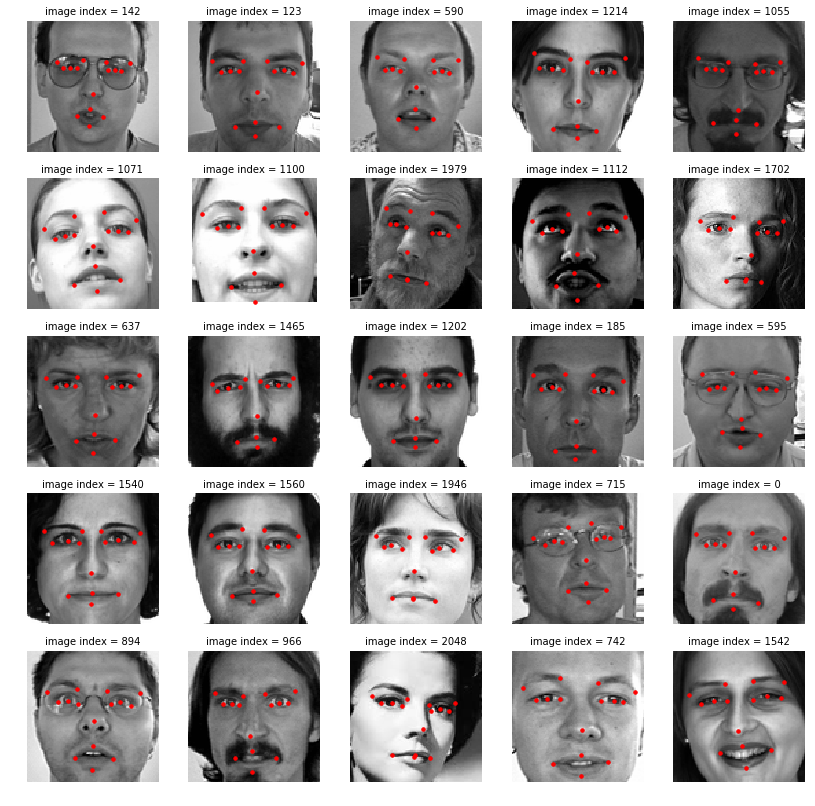

In [7]:
# show a random subset of images from the dataset
num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(faceImagesDB.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,14))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:,:,curr_ind]
    
        x_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind,0:30:2].tolist())
        y_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind,1:30:2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)

In [8]:
# crop boundery for the left eye
listOfKeypointsToAvg = ['left_eye_center_x','left_eye_inner_corner_x','left_eye_outer_corner_x']
facialKeypointsDF['left_eye_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['left_eye_center_y','left_eye_inner_corner_y','left_eye_outer_corner_y']
facialKeypointsDF['left_eye_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 =   facialKeypointsDF['left_eye_BB_y'] - facialKeypointsDF['left_eyebrow_inner_end_y']
dy2 =   facialKeypointsDF['left_eye_BB_y'] - facialKeypointsDF['left_eyebrow_outer_end_y']
dx1 =   facialKeypointsDF['left_eye_BB_x'] - facialKeypointsDF['left_eyebrow_inner_end_x']
dx2 = -(facialKeypointsDF['left_eye_BB_x'] - facialKeypointsDF['left_eyebrow_outer_end_x'])
facialKeypointsDF['left_eye_halfHeight'] = 1.1*0.5*(dy1 + dy2)
facialKeypointsDF['left_eye_halfWidth']  = 1.1*0.5*(dx1 + dx2)


# crop boundry for the right eye
listOfKeypointsToAvg = ['right_eye_center_x','right_eye_inner_corner_x','right_eye_outer_corner_x']
facialKeypointsDF['right_eye_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['right_eye_center_y','right_eye_inner_corner_y','right_eye_outer_corner_y']
facialKeypointsDF['right_eye_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 =   facialKeypointsDF['right_eye_BB_y'] - facialKeypointsDF['right_eyebrow_inner_end_y']
dy2 =   facialKeypointsDF['right_eye_BB_y'] - facialKeypointsDF['right_eyebrow_outer_end_y']
dx1 =   facialKeypointsDF['right_eye_BB_x'] - facialKeypointsDF['right_eyebrow_inner_end_x']
dx2 = -(facialKeypointsDF['right_eye_BB_x'] - facialKeypointsDF['right_eyebrow_outer_end_x'])
facialKeypointsDF['right_eye_halfHeight'] = 1.1*0.5*(dy1 + dy2)
facialKeypointsDF['right_eye_halfWidth']  = -1.1*0.5*(dx1 + dx2)


# crop boundry for the nose
listOfKeypointsToAvg = ['left_eye_inner_corner_x','right_eye_inner_corner_x','mouth_right_corner_x','mouth_left_corner_x','nose_tip_x']
facialKeypointsDF['nose_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['left_eye_inner_corner_y','right_eye_inner_corner_y','mouth_center_top_lip_y','nose_tip_y']
facialKeypointsDF['nose_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

dy1 = abs(facialKeypointsDF['left_eye_inner_corner_y']  - 0.5*(facialKeypointsDF['nose_tip_y']+facialKeypointsDF['mouth_center_top_lip_y']))
dy2 = abs(facialKeypointsDF['right_eye_inner_corner_y'] - 0.5*(facialKeypointsDF['nose_tip_y']+facialKeypointsDF['mouth_center_top_lip_y']))
dx1 = abs(facialKeypointsDF['left_eye_inner_corner_x']  - facialKeypointsDF['right_eye_inner_corner_x'])
dx2 = abs(facialKeypointsDF['mouth_left_corner_x']      - facialKeypointsDF['mouth_right_corner_x'])
facialKeypointsDF['nose_halfWidth']  = 0.25*(dx1 + dx2)
facialKeypointsDF['nose_halfHeight'] = 0.25*(dy1 + dy2)


# crop boundry for the mouth
listOfKeypointsToAvg = ['mouth_center_top_lip_x','mouth_center_bottom_lip_x','mouth_right_corner_x','mouth_left_corner_x']
facialKeypointsDF['mouth_BB_x'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)
listOfKeypointsToAvg = ['mouth_center_top_lip_y','mouth_center_bottom_lip_y','mouth_right_corner_y','mouth_left_corner_y']
facialKeypointsDF['mouth_BB_y'] = facialKeypointsDF.loc[:,listOfKeypointsToAvg].mean(axis=1)

facialKeypointsDF['mouth_halfWidth']  = 1.3*0.5*abs(facialKeypointsDF['mouth_left_corner_x']    - facialKeypointsDF['mouth_right_corner_x'])
facialKeypointsDF['mouth_halfHeight'] = 7.0 + 0.95*0.5*abs(facialKeypointsDF['mouth_center_top_lip_y'] - facialKeypointsDF['mouth_center_bottom_lip_y'])


In [9]:
# show the newly formed columns
facialKeypointsDF.iloc[:5,30:]

,left_eye_BB_x,left_eye_BB_y,left_eye_halfHeight,left_eye_halfWidth,right_eye_BB_x,right_eye_BB_y,right_eye_halfHeight,right_eye_halfWidth,nose_BB_x,nose_BB_y,nose_halfWidth,nose_halfHeight,mouth_BB_x,mouth_BB_y,mouth_halfWidth,mouth_halfHeight
0,66.248662,39.539898,9.799905,12.800626,30.012150,37.066827,8.516124,13.129177,46.033805,51.759771,13.951579,13.241359,44.063278,78.695098,21.177528,12.486400
1,64.637277,35.477197,6.749887,13.555745,30.152170,33.651563,7.754023,14.224919,46.928204,48.890843,11.030128,14.072902,45.924085,77.036596,13.844391,14.226468
2,65.151158,35.850526,6.313166,12.729663,31.186105,35.944611,6.416659,13.971505,47.839326,49.093168,12.207632,12.772200,47.274789,73.649368,17.612811,11.022100
3,65.847930,38.256640,7.654730,11.812049,31.649670,38.007930,8.281091,11.667423,50.470289,50.534880,12.684522,11.594233,51.177183,73.814817,18.429704,10.883930
4,65.935706,39.708996,9.354713,11.282356,30.577767,38.480707,8.444620,12.160261,46.142194,54.328255,12.765791,14.970199,45.263264,78.774773,19.161777,13.252795


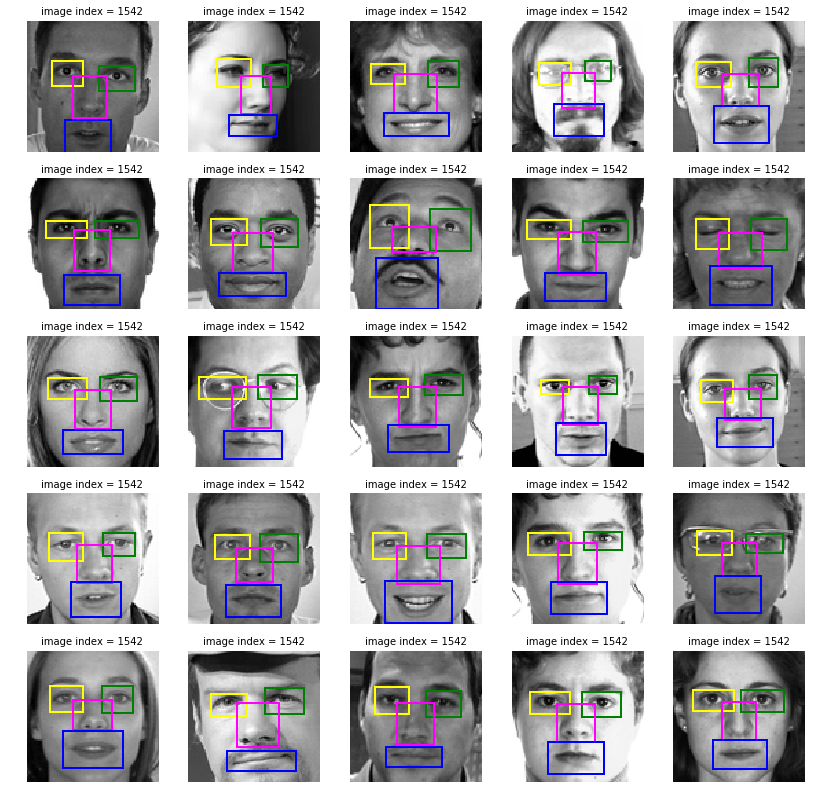

In [10]:
# helper function to convert dataframe fields to rectangle fields
def ExtractBoundingBoxParams(df, fieldNamePremble):
    bottomLeft_x = df.loc[k, fieldNamePremble + '_BB_x'] - df.loc[k, fieldNamePremble + '_halfWidth']
    bottomLeft_y = df.loc[k, fieldNamePremble + '_BB_y'] - df.loc[k, fieldNamePremble + '_halfHeight']
    boxWidth     = 2*df.loc[k, fieldNamePremble + '_halfWidth']
    boxHeight    = 2*df.loc[k, fieldNamePremble + '_halfHeight']
    return bottomLeft_x, bottomLeft_y, boxWidth, boxHeight


num_fig_rows = 5
num_fig_cols = 5
num_plots = num_fig_rows * num_fig_cols
rand_inds_vec = np.random.choice(faceImagesDB.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,14))
for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        k = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:,:,k]
    
        x_feature_coords = np.array(facialKeypointsDF.iloc[k,0:30:2].tolist())
        y_feature_coords = np.array(facialKeypointsDF.iloc[k,1:30:2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        #ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)

        # plot bounding box of all parts with corresponding colors
        listOfPartNames  = [ 'left_eye', 'right_eye',    'nose', 'mouth']
        listOfPartColors = [    'green',    'yellow', 'magenta',  'blue']
        
        for partName, partColor in zip(listOfPartNames, listOfPartColors):
            bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, partName)
            ax[i][j].add_patch(patches.Rectangle( (bottomLeft_x, bottomLeft_y), boxWidth, boxHeight,
                                                   edgecolor=partColor, linewidth=2, fill=False) )

In [11]:
#%% determine part target sizes
targetEyeSize = (np.ceil(2*facialKeypointsDF['left_eye_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['left_eye_halfWidth'].mean()))
targetEyeSize = [int(x) for x in targetEyeSize]

targetNoseSize = (np.ceil(2*facialKeypointsDF['nose_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['nose_halfWidth'].mean()))
targetNoseSize = [int(x) for x in targetNoseSize]

targetMouthSize = (np.ceil(2*facialKeypointsDF['mouth_halfHeight'].mean()),np.ceil(2*facialKeypointsDF['mouth_halfWidth'].mean()))
targetMouthSize = [int(x) for x in targetMouthSize]

In [12]:
#%% go over all images, crop out parts and resize to fit the target size
allLeftEyes  = np.zeros((targetEyeSize[0]  , targetEyeSize[1]  , numImages))
allRightEyes = np.zeros((targetEyeSize[0]  , targetEyeSize[1]  , numImages))
allNoses     = np.zeros((targetNoseSize[0] , targetNoseSize[1] , numImages))
allMouths    = np.zeros((targetMouthSize[0], targetMouthSize[1], numImages))

for k in range(numImages):
    currImage = faceImagesDB[:,:,k]
    
    # crop out left eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'left_eye')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedLeftEye = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]
    
    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'right_eye')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedRightEye = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]

    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'nose')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedNose = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]

    # crop out right eye
    bottomLeft_x, bottomLeft_y, boxWidth, boxHeight = ExtractBoundingBoxParams(facialKeypointsDF, 'mouth')
    hLims = (max(0,np.floor(bottomLeft_y).astype(int)), min(imHeight,np.ceil(bottomLeft_y + boxHeight).astype(int)))
    wLims = (max(0,np.floor(bottomLeft_x).astype(int)), min(imWidth ,np.ceil(bottomLeft_x + boxWidth ).astype(int)))
    croppedMouth = currImage[hLims[0]:hLims[1],wLims[0]:wLims[1]]
    
    allLeftEyes[:,:,k]  = tf.resize(croppedLeftEye,targetEyeSize)
    allRightEyes[:,:,k] = tf.resize(croppedRightEye,targetEyeSize)
    allNoses[:,:,k]     = tf.resize(croppedNose,targetNoseSize)
    allMouths[:,:,k]    = tf.resize(croppedMouth,targetMouthSize)

c:\users\lina\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\lina\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


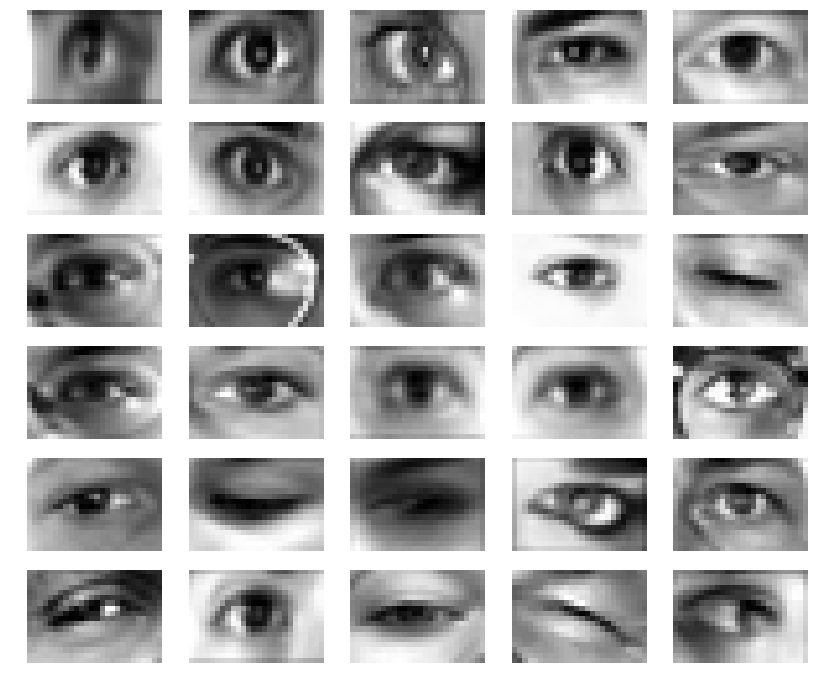

In [13]:
# plot eyes
numFigRows = 6
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,12))
for i in range(numFigRows):
    for j in range(numFigCols):
        if np.random.rand(1) < 0.5:
            ax[i][j].imshow(allLeftEyes[:,:,randIndsMat[i][j]], cmap='gray');
        else:
            ax[i][j].imshow(np.fliplr(allLeftEyes[:,:,randIndsMat[i][j]]), cmap='gray');
        ax[i][j].set_axis_off()

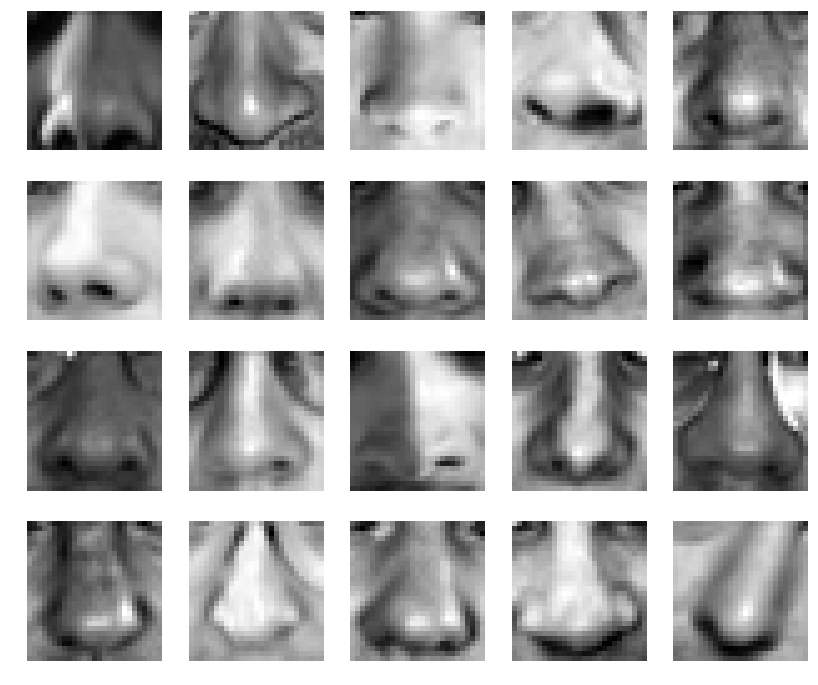

In [14]:
# plot noses
numFigRows = 4
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,12))
for i in range(numFigRows):
    for j in range(numFigCols):
        ax[i][j].imshow(allNoses[:,:,randIndsMat[i][j]], cmap='gray');
        ax[i][j].set_axis_off()

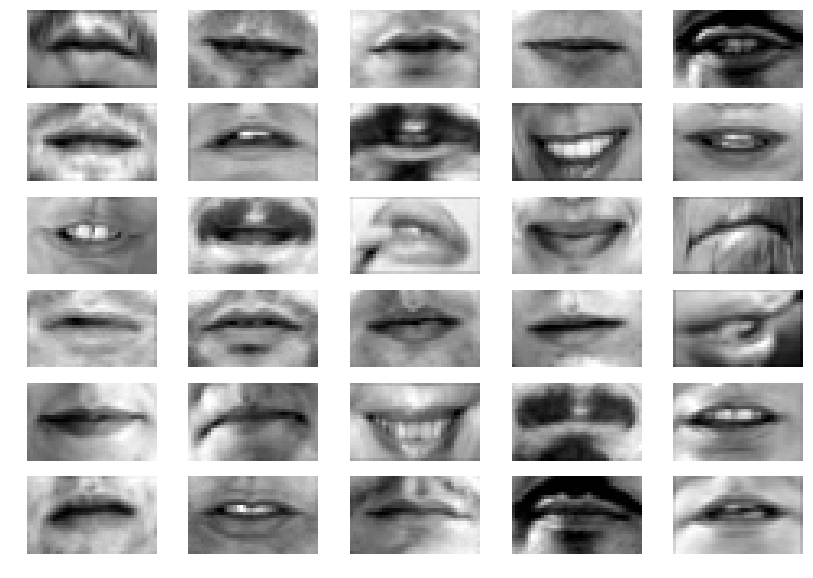

In [15]:
# plot mouths
numFigRows = 6
numFigCols = 5
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,10))
for i in range(numFigRows):
    for j in range(numFigCols):
        ax[i][j].imshow(allMouths[:,:,randIndsMat[i][j]], cmap='gray');
        ax[i][j].set_axis_off()

In [16]:
#%% flatten the 3D datasets (imHeight,imWidth,numSamples) to 2D datasets (numSamples,numDimentions)
def FlattenImageDataset(imageDB):
    # assume imageDB.shape = (imHeight, imWidth, numSamples)
    numSamples = imageDB.shape[2]
    numFeatures = imageDB.shape[0] * imageDB.shape[1]
    imageDB_flattened = np.reshape(np.transpose(imageDB,axes=(2,0,1)),(numSamples,numFeatures))
    return imageDB_flattened

allLeftEyes_flat  = FlattenImageDataset(allLeftEyes)
allRightEyes_flat = FlattenImageDataset(np.fliplr(allRightEyes))
allNoses_flat     = FlattenImageDataset(allNoses)
allMouths_flat    = FlattenImageDataset(allMouths)

print('previous eye dataset shape was ' + str(allLeftEyes.shape))
print('current eye dataset shape is ' + str(allLeftEyes_flat.shape))

previous eye dataset shape was (18, 26, 2140)
current eye dataset shape is (2140, 468)


In [17]:
#%% determine the number of clusters for the eyes, nose and mouth
def DetermineNumClusters(imageDB_flattened, percentExplainedTarget=70, plotFigure=True):
    # run a loop in which you apply kmeans in increasing number of n_clusters and collect the inertia_ field from the result
    listOfNumClusters = [1,2,4,9,16,25,36,49,64,128,256]
    listOfInertia = []
    for numClusters in listOfNumClusters:
        KmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=750, n_init=1, random_state=1)
        KmeansModel.fit(imageDB_flattened)
        listOfInertia.append(KmeansModel.inertia_)
    explainedPercent = 100*(1-(np.array(listOfInertia)/listOfInertia[0]))

    # calculate the desired number of clusters
    try:
        numDesiredClusterInd = np.nonzero(explainedPercent > percentExplainedTarget)[0][0]
        numDesiredClusters = listOfNumClusters[numDesiredClusterInd]
    except:
        print("desired target exceeds %d" %(listOfNumClusters[-1]))
        numDesiredClusterInd = len(listOfNumClusters)
        numDesiredClusters = listOfNumClusters[numDesiredClusterInd]
            
    if plotFigure:
        # plot the explained percent as a function of number of clusters 
        explainedPercentReached = explainedPercent[numDesiredClusterInd]
        plt.figure(figsize=(14,6)); plt.plot(listOfNumClusters,explainedPercent,c='b')
        plt.scatter(numDesiredClusters,explainedPercentReached,s=150,c='r')
        plt.xlabel('Number of Clusters', fontsize=20); plt.ylabel('Explained Percent', fontsize=20)
        plt.title('Desired Number of Clusters = %d, Explained Percent = %.2f%s' %(numDesiredClusters,explainedPercentReached,'%'),fontsize=25)
        plt.xlim(-1,listOfNumClusters[-1]+1); plt.ylim(0,100)
    return numDesiredClusters

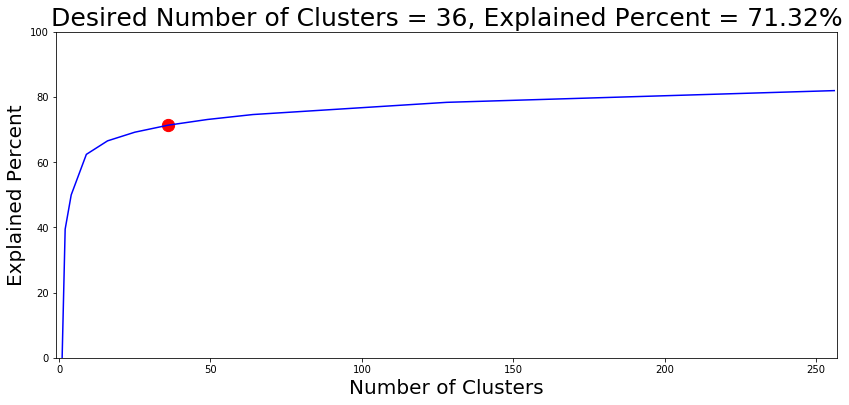

In [18]:
numClusters_eyes  = DetermineNumClusters(np.concatenate((allLeftEyes_flat, allRightEyes_flat)), plotFigure=True)

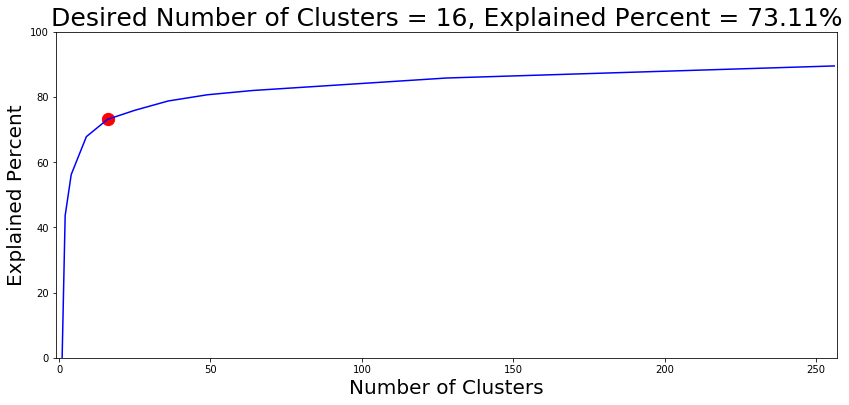

In [19]:
numClusters_nose  = DetermineNumClusters(allNoses_flat , plotFigure=True)

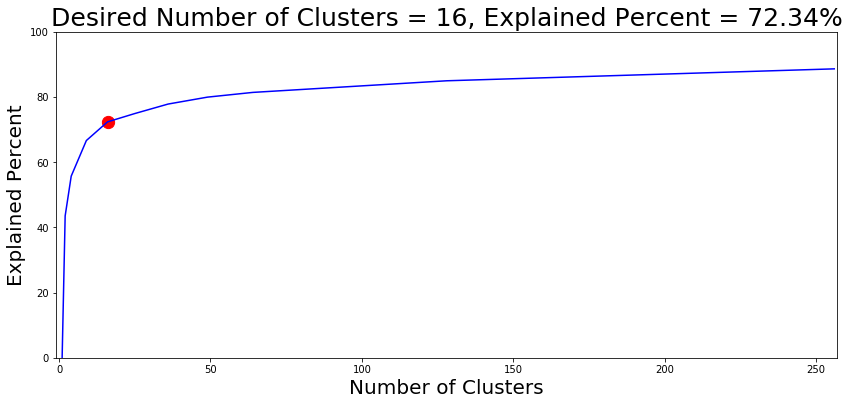

In [20]:
numClusters_mouth = DetermineNumClusters(allMouths_flat, plotFigure=True)

In [22]:
#%% fit models with desired number of clusters
KmeansModel_nose  = cluster.KMeans(n_clusters=numClusters_nose , n_init=10, random_state=1)
KmeansModel_nose.fit(allNoses_flat)

KmeansModel_mouth = cluster.KMeans(n_clusters=numClusters_mouth, n_init=10, random_state=1)
KmeansModel_mouth.fit(allMouths_flat)

KmeansModel_eyes  = cluster.KMeans(n_clusters=numClusters_eyes , n_init=10, random_state=1)
KmeansModel_eyes.fit(np.concatenate((allLeftEyes_flat, allRightEyes_flat)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=36, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [23]:
#%% Show the resulting eye, nose and mouth clusters
def ShowKmeansClustersAsImages(KmeansModel, origImDims, title):
    clusterAssignments = KmeansModel.labels_
    subPlotRowsAndCols = np.ceil(np.sqrt(KmeansModel.n_clusters)).astype(int)
    
    plt.figure(figsize=(14,11));
    plt.suptitle(title, fontsize=30)
    for k in range(subPlotRowsAndCols**2):
        percentAssigned = 100.0 * (clusterAssignments == k).sum() / len(clusterAssignments)
        currCenterImage = np.reshape(KmeansModel.cluster_centers_[k,:],(origImDims[0],origImDims[1]))
    
        plt.subplot(subPlotRowsAndCols,subPlotRowsAndCols,k+1); plt.axis('off');
        plt.imshow(currCenterImage,cmap='gray');
        plt.title('%.2f%s assignment' %(percentAssigned,'%'), fontsize=11);

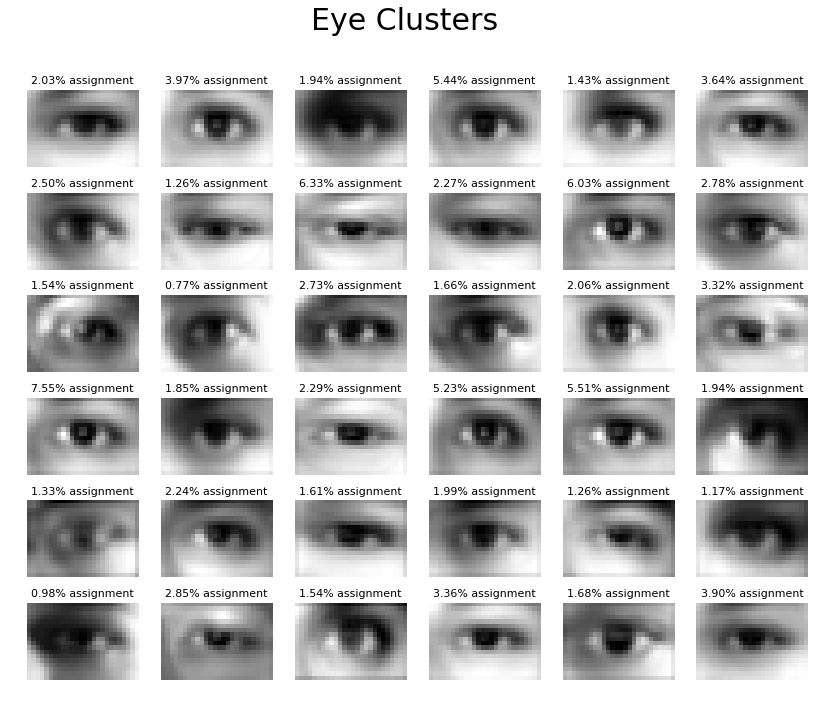

In [24]:
ShowKmeansClustersAsImages(KmeansModel_eyes , allLeftEyes.shape[0:2], 'Eye Clusters')

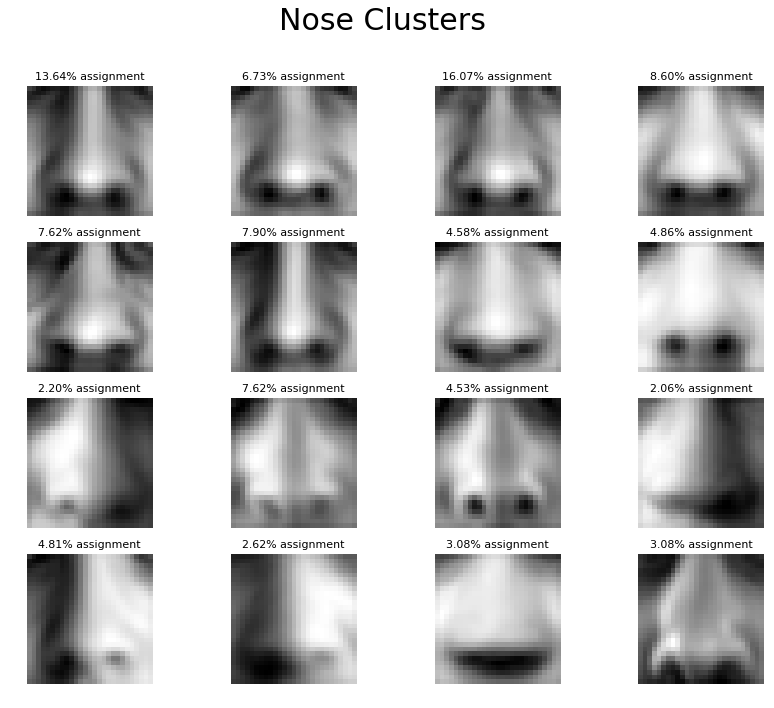

In [25]:
ShowKmeansClustersAsImages(KmeansModel_nose , allNoses.shape[0:2]   , 'Nose Clusters')

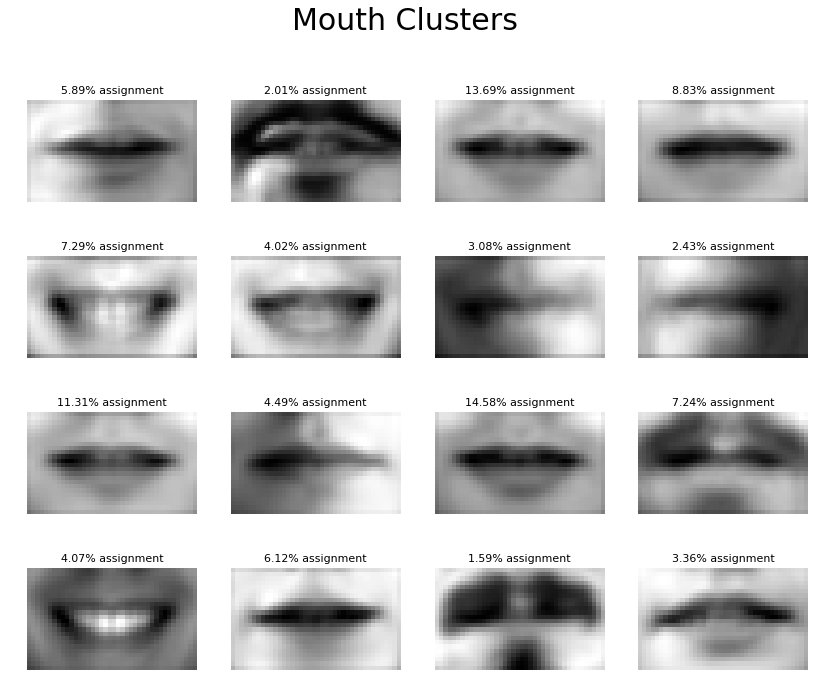

In [26]:
ShowKmeansClustersAsImages(KmeansModel_mouth, allMouths.shape[0:2]  , 'Mouth Clusters')

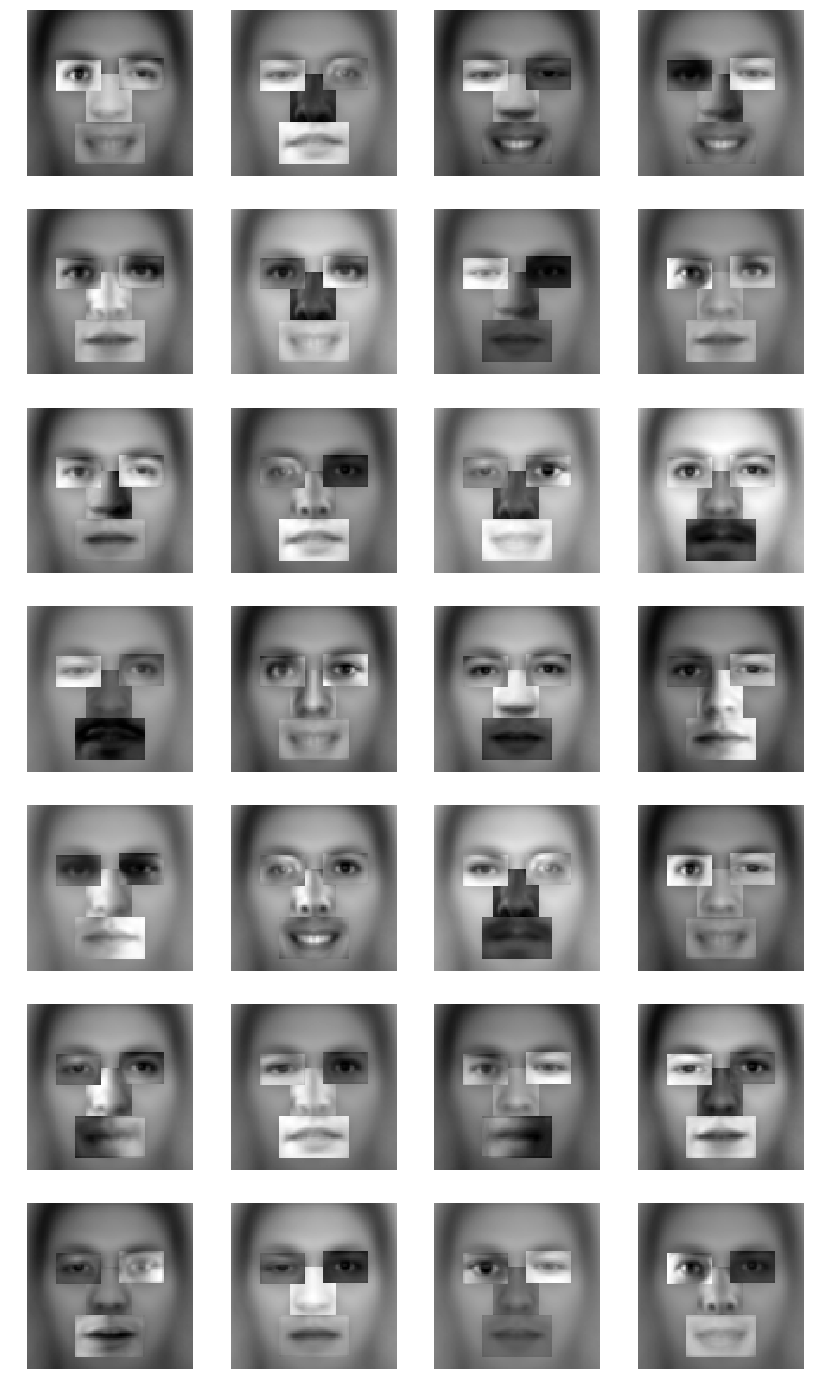

In [27]:
#%% Generate Caricature Faces out of Facial Parts
noseRowCoords     = np.floor(np.array([-0.5,0.5])*targetNoseSize[0] + int(round(facialKeypointsDF.loc[:,'nose_BB_y'].mean()))).astype(int)
noseColCoords     = np.floor(np.array([-0.5,0.5])*targetNoseSize[1] + int(round(facialKeypointsDF.loc[:,'nose_BB_x'].mean()))).astype(int)

mouthRowCoords    = np.floor(np.array([-0.5,0.5])*targetMouthSize[0] + int(round(facialKeypointsDF.loc[:,'mouth_BB_y'].mean()))).astype(int)
mouthColCoords    = np.floor(np.array([-0.5,0.5])*targetMouthSize[1] + int(round(facialKeypointsDF.loc[:,'mouth_BB_x'].mean()))).astype(int)

leftEyeRowCoords  = np.floor(np.array([-0.5,0.5])*targetEyeSize[0] + int(round(facialKeypointsDF.loc[:,'left_eye_BB_y'].mean()))).astype(int)
leftEyeColCoords  = np.floor(np.array([-0.5,0.5])*targetEyeSize[1] + int(round(facialKeypointsDF.loc[:,'left_eye_BB_x'].mean()))).astype(int)

rightEyeRowCoords = np.floor(np.array([-0.5,0.5])*targetEyeSize[0] + int(round(facialKeypointsDF.loc[:,'right_eye_BB_y'].mean()))).astype(int)
rightEyeColCoords = np.floor(np.array([-0.5,0.5])*targetEyeSize[1] + int(round(facialKeypointsDF.loc[:,'right_eye_BB_x'].mean()))).astype(int)

# plot mouths
numFigRows = 7
numFigCols = 4
numPlots = numFigRows * numFigCols
randIndsVec = np.random.choice(numImages,numPlots,replace=False)
randIndsMat = randIndsVec.reshape((numFigRows,numFigCols))

fig, ax = plt.subplots(nrows=numFigRows,ncols=numFigCols,figsize=(14,25))
for i in range(numFigRows):
    for j in range(numFigCols):
        #generatedImage = 128.0*np.ones((imHeight,imWidth))
        generatedImage = faceImagesDB.mean(axis=2)
        
        # generate nose
        k = np.random.randint(numClusters_nose)
        noseImage = np.reshape(KmeansModel_nose.cluster_centers_[k,:],targetNoseSize)
        generatedImage[noseRowCoords[0]:noseRowCoords[1],noseColCoords[0]:noseColCoords[1]] = noseImage
        
        # select mouth
        k = np.random.randint(numClusters_mouth)
        mouthImage = np.reshape(KmeansModel_mouth.cluster_centers_[k,:],targetMouthSize)
        generatedImage[mouthRowCoords[0]:mouthRowCoords[1],mouthColCoords[0]:mouthColCoords[1]] = mouthImage
        
        # select left eye
        k = np.random.randint(numClusters_eyes)
        leftEyeImage = np.reshape(KmeansModel_eyes.cluster_centers_[k,:],targetEyeSize)
        generatedImage[leftEyeRowCoords[0]:leftEyeRowCoords[1],leftEyeColCoords[0]:leftEyeColCoords[1]] = leftEyeImage
        
        # select right eye
        k = np.random.randint(numClusters_eyes)
        rightEyeImage = np.reshape(KmeansModel_eyes.cluster_centers_[k,:],targetEyeSize)
        generatedImage[rightEyeRowCoords[0]:rightEyeRowCoords[1],rightEyeColCoords[0]:rightEyeColCoords[1]] = np.fliplr(rightEyeImage)
                
        # show the resulting image
        ax[i][j].imshow(generatedImage, cmap='gray');
        ax[i][j].set_axis_off()


In [28]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12,12)

In [30]:
# load the dataset
face_images_db = np.load('D:/face_points/face_images.npz')['face_images']
facial_keypoints_df = pd.read_csv('D:/face_points/facial_keypoints.csv')

(im_height, im_width, num_images) = face_images_db.shape
num_keypoints = facial_keypoints_df.shape[1] / 2

print('number of images = %d' %(num_images))
print('image dimentions = (%d,%d)' %(im_height,im_width))
print('number of facial keypoints = %d' %(num_keypoints))

number of images = 7049
image dimentions = (96,96)
number of facial keypoints = 15


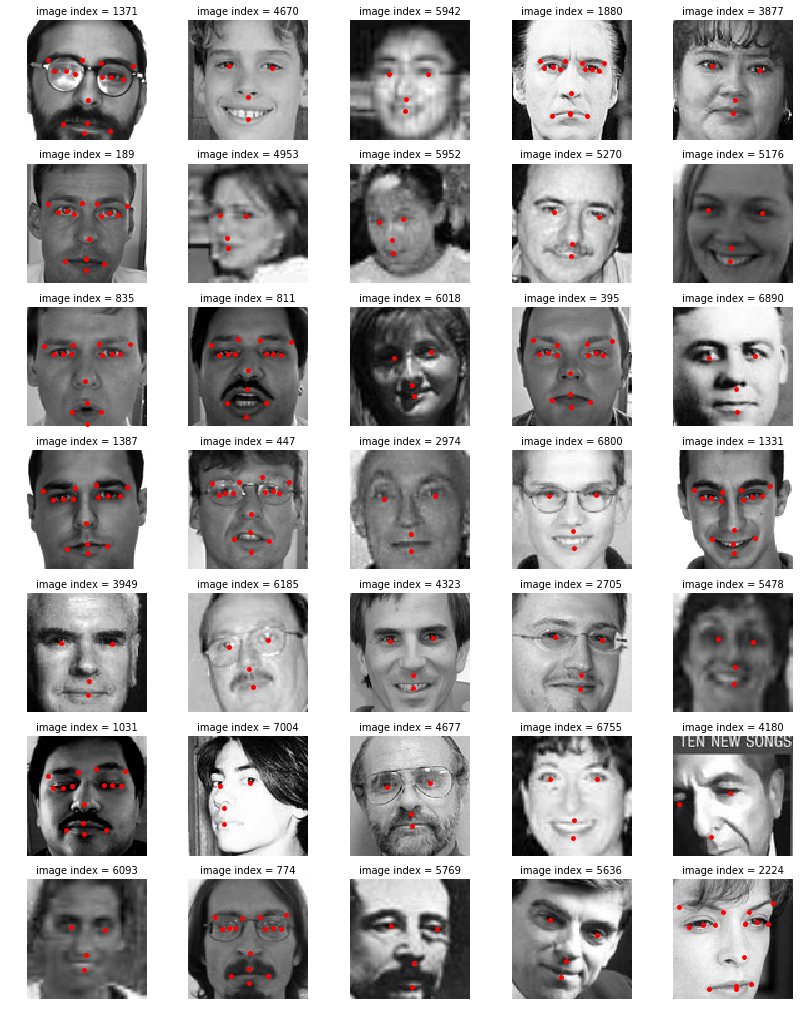

In [31]:
# show a random subset of images from the dataset
    
num_fig_rows = 7
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(face_images_db.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,18))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = face_images_db[:,:,curr_ind]
    
        x_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,0::2].tolist())
        y_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,1::2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=15)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)


Text(0.5,1,'stdev image')

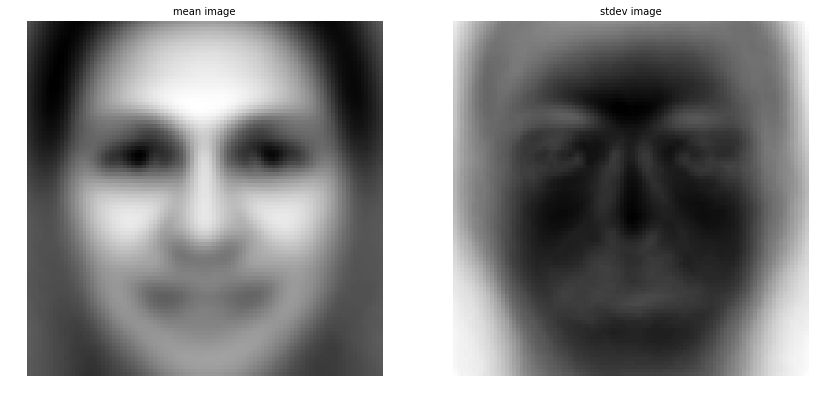

In [32]:
# show the mean face image and the standard deviation image
        
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,14))
        
ax[0].imshow(face_images_db.mean(axis=2), cmap='gray');
ax[0].set_axis_off(); ax[0].set_title('mean image',fontsize=10)
        
ax[1].imshow(face_images_db.std(axis=2), cmap='gray');
ax[1].set_axis_off(); ax[1].set_title('stdev image',fontsize=10)


Text(0,0.5,'number of images')

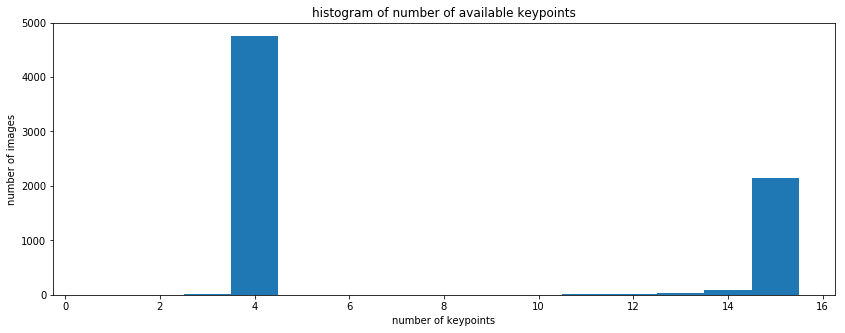

In [33]:
# show the histogram of the number of available keypoints per image

num_available_keypoints = num_keypoints - facial_keypoints_df.isnull().sum(axis=1)/2

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,5))
ax.hist(num_available_keypoints,bins=0.5+np.arange(num_keypoints+1))
ax.set_title('histogram of number of available keypoints')
ax.set_xlabel('number of keypoints'); ax.set_ylabel('number of images')


In [34]:
fraction_present_keypoints = 1.0 - facial_keypoints_df.iloc[:,0::2].isnull().mean(axis=0)

fraction_present_keypoints

left_eye_center_x            0.998581
right_eye_center_x           0.998156
left_eye_inner_corner_x      0.322173
left_eye_outer_corner_x      0.321606
right_eye_inner_corner_x     0.321748
right_eye_outer_corner_x     0.321748
left_eyebrow_inner_end_x     0.322031
left_eyebrow_outer_end_x     0.315648
right_eyebrow_inner_end_x    0.322031
right_eyebrow_outer_end_x    0.317208
nose_tip_x                   1.000000
mouth_left_corner_x          0.321890
mouth_right_corner_x         0.322031
mouth_center_top_lip_x       0.322741
mouth_center_bottom_lip_x    0.995318
dtype: float64

Text(0.5,1,'4 keypoints (eyes, nose, mouth) scatter plot')

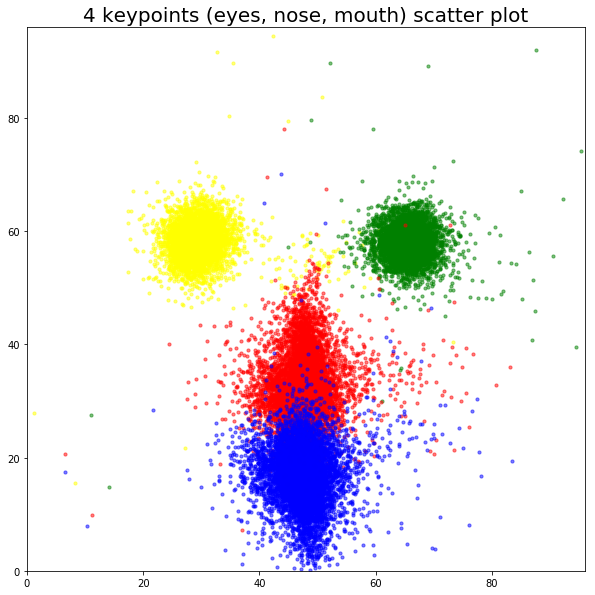

In [35]:
# show the scatter plot of all locations of several selected keypoints

# create a map of what color you want to display different keypoints
keypointColors = {}
keypointColors['left_eye_center'] = 'yellow'
keypointColors['right_eye_center'] = 'green'
keypointColors['nose_tip'] = 'red'
keypointColors['mouth_center_bottom_lip'] = 'blue'

# get all inds of image where the requested keypoints are present
keypoint_present_inds = np.ones(num_images) == 1
for key in keypointColors.keys():
    keypoint_present_inds = keypoint_present_inds & (facial_keypoints_df.isnull()[key+'_x'] == False)
keypoint_present_inds = np.nonzero(keypoint_present_inds)[0]

plt.figure(figsize=(10,10))
for key,value in keypointColors.items():
    x_feature_coords = im_width  - np.array(facial_keypoints_df.loc[keypoint_present_inds,key+'_x'].tolist())
    y_feature_coords = im_height - np.array(facial_keypoints_df.loc[keypoint_present_inds,key+'_y'].tolist())
    plt.scatter(x_feature_coords,y_feature_coords,c=value,s=10,alpha=0.5)
plt.xlim(0,im_width); plt.ylim(0,im_height)
plt.title('4 keypoints (eyes, nose, mouth) scatter plot', fontsize=20)

Text(0.5,1,'15 keypoints scatter plot')

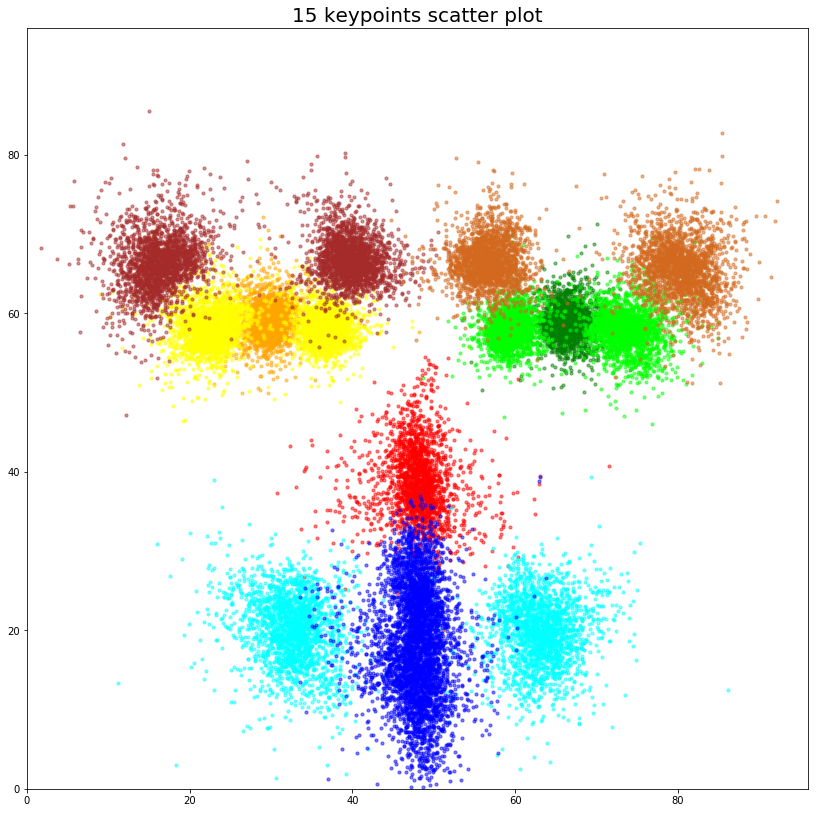

In [36]:
# show the scatter plot of all locations of several selected keypoints

# create a map of what color you want to display different keypoints
keypointColors = {}
keypointColors['left_eye_center'] = 'orange'
keypointColors['left_eye_inner_corner'] = 'yellow'
keypointColors['left_eye_outer_corner'] = 'yellow'
keypointColors['left_eyebrow_inner_end'] = 'brown'
keypointColors['left_eyebrow_outer_end'] = 'brown'

keypointColors['right_eye_center'] = 'green'
keypointColors['right_eye_inner_corner'] = 'lime'
keypointColors['right_eye_outer_corner'] = 'lime'
keypointColors['right_eyebrow_inner_end'] = 'chocolate'
keypointColors['right_eyebrow_outer_end'] = 'chocolate'

keypointColors['nose_tip'] = 'red'

keypointColors['mouth_left_corner']       = 'cyan'
keypointColors['mouth_right_corner']      = 'cyan'
keypointColors['mouth_center_top_lip']    = 'blue'
keypointColors['mouth_center_bottom_lip'] = 'blue'

# get all inds of image where the requested keypoints are present
keypoint_present_inds = np.ones(num_images) == 1
for key in keypointColors.keys():
    keypoint_present_inds = keypoint_present_inds & (facial_keypoints_df.isnull()[key+'_x'] == False)
keypoint_present_inds = np.nonzero(keypoint_present_inds)[0]

plt.figure(figsize=(14,14))
for key,value in keypointColors.items():
    x_feature_coords = im_width  - np.array(facial_keypoints_df.loc[keypoint_present_inds,key+'_x'].tolist())
    y_feature_coords = im_height - np.array(facial_keypoints_df.loc[keypoint_present_inds,key+'_y'].tolist())
    plt.scatter(x_feature_coords,y_feature_coords,c=value,s=10,alpha=0.5)
plt.xlim(0,im_width); plt.ylim(0,im_height)
plt.title('15 keypoints scatter plot', fontsize=20)

In [1]:
import cv2
import numpy as np
import dlib

cap = cv2.VideoCapture(0)
pred_dir ="C:/Users/Lina/AppData/Local/Programs/Python/Python36/Lib/site-packages/dlib/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(pred_dir)

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(frame, (x, y), 1, (255, 0, 0), -1)


    cv2.imshow("Frame", frame)


    if  cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()